In [2]:
import tensorflow as tf
from tensorflow import keras

from nn.models import C6_4l_clf_mini, swish_activation
from nn import datasets
from hstar import process, trilinear
from hzz import zcandidate, angles

import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
GEN=2
OUTPUT_DIR='outputs/single'
SAMPLE_DIR='..'

In [5]:
sample = process.Sample(weight='wt', 
    amplitude = process.Basis.SBI, components = {
    process.Basis.SBI: 'msq_sbi_sm',
    process.Basis.SIG: 'msq_sig_sm',
    process.Basis.BKG: 'msq_bkg_sm',
    process.Basis.INT: 'msq_int_sm'
  })

sample.open(csv = [
  SAMPLE_DIR + '/ggZZ2e2m_all_new.csv',
  SAMPLE_DIR + '/ggZZ4e_all_new.csv',
  SAMPLE_DIR + '/ggZZ4m_all_new.csv'
  ], xs=[1.4783394, 0.47412769, 0.47412769], lumi=3000., k=1.83, nrows=[2500000,1250000,1250000]
)

sample.events = sample.events.sample(frac=1).reset_index(drop=True).iloc[4000000:]

print(sample.events.shape)

zmasses = zcandidate.ZmassPairChooser(sample)
leptons = zmasses.find_Z()

print(sample.events.shape)

kin_variables = angles.calculate(leptons.T[0], leptons.T[1], leptons.T[2], leptons.T[3])

print(sample.events.shape)

c6_values = [20]

c6_mod = trilinear.Modifier(c6_values = [-5,-1,0,1,5], c6_amplitudes = ['msq_sbi_c6_6', 'msq_sbi_c6_10', 'msq_sbi_c6_11', 'msq_sbi_c6_12', 'msq_sbi_c6_16'])
c6_weights = c6_mod.modify(sample=sample, c6=c6_values)

(1000000, 97)
Deleting refs p12, p23, p14, p34
Deleting ref chi_sq
Deleting ref cond
Deleting refs pairs, lepton_pairs, closest_pair_indices, closest_pair, pT_max_ind, pT_min_ind
0
(957340, 97)
(957340, 97)


2024-11-14 17:44:50.508813: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Non param


In [ ]:
test_data = datasets.build_dataset_tf(x_arr = kin_variables,
                                      param_values = c6_values,
                                      signal_weights = c6_weights,
                                      background_weights = tf.convert_to_tensor(sample.events['wt']), 
                                      normalization = 1)

test_data = tf.random.shuffle(test_data)

print(test_data, test_data.shape)

In [6]:
print(test_data, test_data.shape)

tf.Tensor(
[[1.8924016e+02 1.0000000e+00 2.9934600e-07]
 [1.8972662e+02 0.0000000e+00 6.4543104e-07]
 [2.2823543e+02 0.0000000e+00 1.1155320e-06]
 ...
 [2.8509735e+02 1.0000000e+00 3.4298506e-07]
 [1.9895319e+02 0.0000000e+00 4.7390091e-07]
 [2.8485950e+02 1.0000000e+00 6.1741468e-07]], shape=(1914680, 3), dtype=float32) (1914680, 3)


In [7]:
model = keras.models.load_model('outputs/m4l/single/ckpt/checkpoint.model_1_m4l.keras', custom_objects={'C6_4l_clf_mini': C6_4l_clf_mini, 'swish_activation': swish_activation})

ValueError: File not found: filepath=outputs/single/m4l/ckpt/checkpoint.model_1_m4l.keras. Please ensure the file is an accessible `.keras` zip file.

In [8]:
predictions = []
real_ratios = []

arr_len = test_data.shape[0]/len(c6_values)

for i in range(len(c6_values)):
    c6 = c6_values[i]
    data = test_data[int(i*arr_len):int((i+0.5)*arr_len),0][:,np.newaxis]
    pred = model.predict(data)
    predictions.append(pred)

    real_ratio = test_data[int(i*arr_len):int((i+0.5)*arr_len),2]/test_data[int((i+0.5)*arr_len):int((i+1)*arr_len),2]
    real_ratios.append(real_ratio)

predictions = tf.convert_to_tensor(predictions)

ratios = tf.squeeze(predictions/(1-predictions), axis=2)

print(ratios)

real_ratios = tf.convert_to_tensor(real_ratios)

print(real_ratios)

I0000 00:00:1731538985.671171   46057 service.cc:148] XLA service 0x1470d02c8230 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731538985.703098   46057 service.cc:156]   StreamExecutor device (0): Host, Default Version
2024-11-14 00:03:06.947589: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731538989.739885   46057 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


29921/29921 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step
tf.Tensor([[1.0380993 1.0078717 1.0102607 ... 1.0065677 1.0100367 1.0095242]], shape=(1, 957441), dtype=float32)
tf.Tensor([[0.22574149 0.50460154 0.41026202 ... 4.7017007  1.2689257  0.67681384]], shape=(1, 957441), dtype=float32)


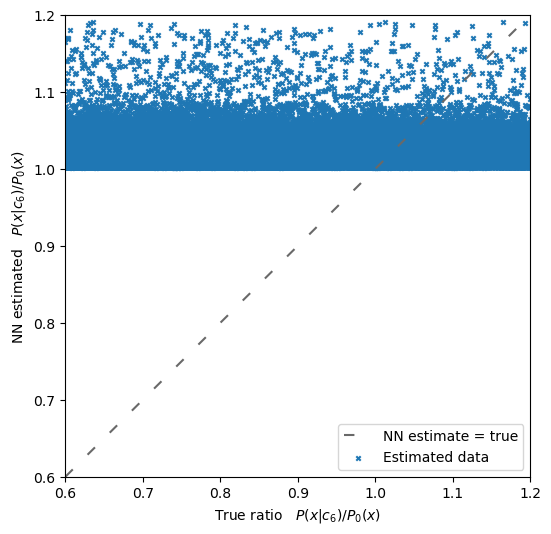

In [9]:
real = real_ratios.numpy()
pred = ratios.numpy()

lnspc = np.linspace(0.6,1.2)

plt.figure(figsize=(6,6))

plt.plot(lnspc, lnspc, color='dimgray', linestyle=(0,(5,10)), label='NN estimate = true')
plt.scatter(real, pred, s=10, marker='x', label='Estimated data')
plt.xlabel(u'True ratio   $P(x|c_6)/P_0(x)$')
plt.ylabel(u'NN estimated   $P(x|c_6)/P_0(x)$')
plt.xlim(0.0,2.0)
plt.ylim(0.0,2.0)
plt.legend()



In [3]:
hist_prm = ''

with open(f'outputs/m4l/single/history/history_2_m4l.txt', 'r') as hist_file:
    hist_prm = hist_file.readlines()

hist_prm = [ np.array(el.replace('[','').replace(']','').replace(' ','').split(','), dtype=float) for el in hist_prm[0].split('][')]

t_loss_prm = np.array(hist_prm[0])
v_loss_prm = np.array(hist_prm[1])

epochs = range(1,101)

NameError: name 'np' is not defined

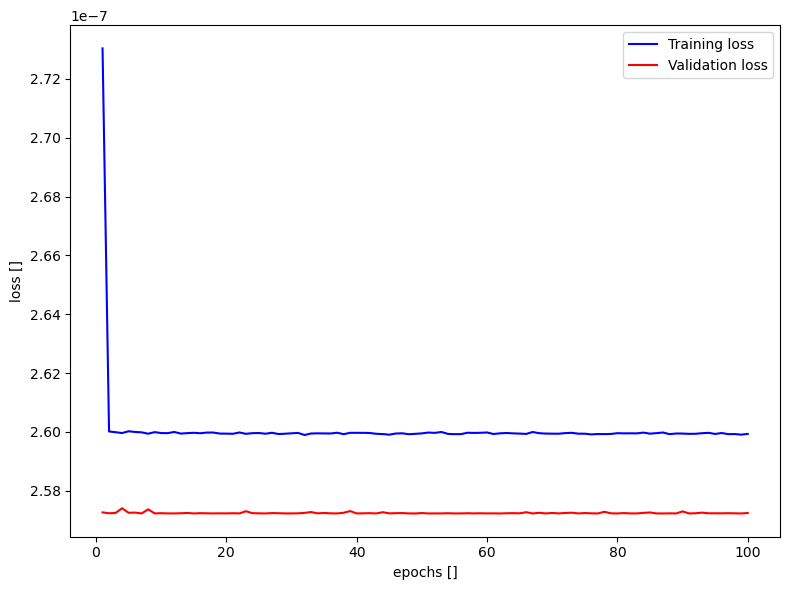

In [11]:
fig = plt.figure(figsize=(8,6))

#ax1.set_xticklabels([])

plt.plot(epochs, t_loss_prm, 'b', label='Training loss')
plt.xlabel('epochs []')
plt.ylabel('loss []')
#ax2.legend()

plt.plot(epochs, v_loss_prm, 'r', label='Validation loss')
#ax1.set_ylabel('loss []')
plt.legend()

fig.tight_layout()

plt.show()